# Demonstration of Self-Organizing Maps (SOMs)
#### by Elizabeth Barnes


In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import Counter

if(IN_COLAB):
    !pip install MiniSom
from minisom import MiniSom   

import numpy.linalg as LA

import matplotlib as mpl
import seaborn as sns

import pandas as pd


# set figure defaults
fig_text_default = 12.
fig_title_default = fig_text_default*1.1
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 125

#plt.rc('lines', linewidth=linewidth_default)    
#plt.rc('text', usetex=False)
#mpl.rcParams['xtick.labelsize'] = fig_text_default

sns.set()
sns.set_style("whitegrid")



IN_COLAB = False


In [2]:
# set random seed so we get identical results every time
%env PYTHONHASHSEED=99
np.random.seed(99)

env: PYTHONHASHSEED=99


### Get your data together

In [3]:
filename = 'http://www.atmos.colostate.edu/fccwx/fccwx_data.php?end=2018-04-15&span=365&interval=hourly&units=m&fmt=csv'
data_0 = pd.read_csv(filename,header=0)
print(np.shape(data_0))

filename = 'http://www.atmos.colostate.edu/fccwx/fccwx_data.php?end=2019-04-15&span=365&interval=hourly&units=m&fmt=csv'
data_1 = pd.read_csv(filename,header=0)
print(np.shape(data_1))

filename = 'http://www.atmos.colostate.edu/fccwx/fccwx_data.php?end=2020-04-15&span=365&interval=hourly&units=m&fmt=csv'
data_2 = pd.read_csv(filename,header=0)
print(np.shape(data_2))

df = data_0.append(data_1).append(data_2)

# drop the units row (first row)
df = df.drop(index=0)
#sort values by date
df = df.sort_values(by=['DateTime'])
print(np.shape(df))
df

# print(data[0])
# print(data.shape[0]/(24.))

(8785, 11)
(8785, 11)
(8785, 11)
(26352, 11)


,DateTime,Temp,RH,DewPt,Wind,Dir,Gust,GustDir,Press,Solar,Prec
8784,2017-04-15 00:00,9.91,42.91,-2.1180942498163,2.765,300,4.841,310,835.578,0,0
8783,2017-04-15 01:00,8.43,37.88,-5.1194364986098,2.175,351,4.136,301,835.72,0,0
8782,2017-04-15 02:00,8.55,39.57,-4.4336193197988,3.497,8,4.743,340,836.932,0,0
8781,2017-04-15 03:00,7.798,42.01,-4.3172914266818,2.12,329,4.469,1,836.911,0,0
8780,2017-04-15 04:00,5.636,52.17,-3.4094838206886,1.847,130,4.41,313,836.436,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5,2020-04-15 19:00,1.682,89.6,0.15726779199476,2.342,276,4.488,293,839.903,7.462,0
4,2020-04-15 20:00,2.049,87.1,0.12871083811986,2.199,308,5.39,353,840.521,0,0
3,2020-04-15 21:00,0.392,96.4,-0.11382187858433,1.298,30,2.43,311,841.451,0.044,2.286
2,2020-04-15 22:00,-0.129,98.1,-0.39278105760288,2.86,29,6.703,59,841.862,0.126,0.762


In [4]:
grab_indices = [1,2,4,8,9,10]

data = df.values[:,grab_indices].astype('float')

names_input = ['dateTime', 'temp (C)', 'RH (%)', 'DewPt (C)','Wind (m/s)', 'Dir (deg.N)', 'Gust (m/s)', 'Gust Dir (deg.N)','Pres (hPa)', 'Solar (W/m^2)','Precip (mm)']
names = [names_input[i] for i in grab_indices]

# convert precip inches to mm
# data[:,[i for i, s in enumerate(names) if 'Precip' in s]] = data[:,[i for i, s in enumerate(names) if 'Precip' in s]]*25.4
# names[names.index('Precip (in)')] = 'Precip (mm)'

In [5]:
print(names)
print(data.shape)

['temp (C)', 'RH (%)', 'Wind (m/s)', 'Pres (hPa)', 'Solar (W/m^2)', 'Precip (mm)']
(26352, 6)


In [6]:
# normalize the data
data = (data - np.mean(data,axis=0))/np.std(data,axis=0)

In [25]:
# make initial SOM shape
dim = (8,8)
som = MiniSom(dim[0],dim[1],np.shape(data)[1], sigma=1.0, learning_rate = .01, neighborhood_function='gaussian')

# more like k-means
# dim = (2,2)
# som = MiniSom(dim[0],dim[1],np.shape(data)[1], sigma=.2, learning_rate = .1, neighborhood_function='gaussian')

In [26]:
# initialize with PC weights when you have a square
if(np.min(dim)>1):
    som.pca_weights_init(data)

In [27]:
som.train_random(data, 50000, verbose=True) # train over a random group of data 

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.27955953873447625
 topographic error: 0.055783242258652097


In [28]:
codebook = som.get_weights()
print(np.shape(codebook))

(8, 8, 6)


In [29]:
dataNeurons = som.quantization(data)
np.shape(dataNeurons)

(26352, 6)

Let's look at one particular sample.

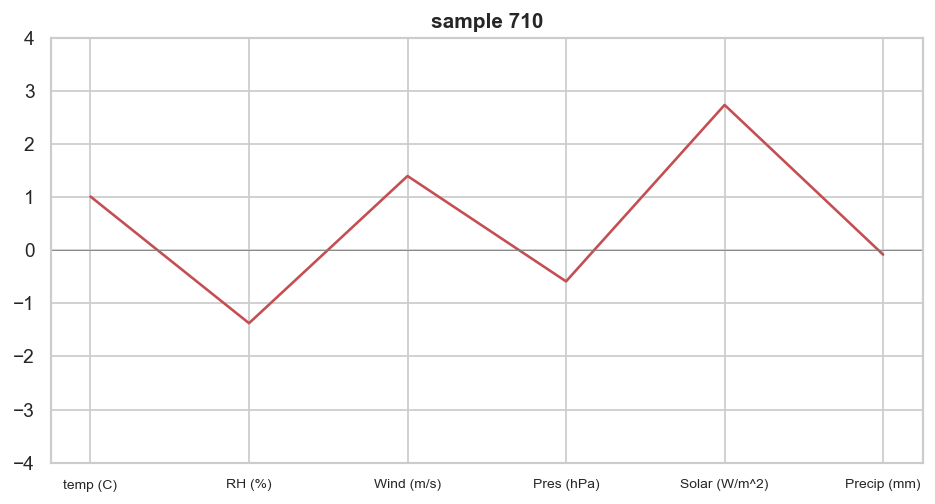

(1, 0)


In [31]:
sample = 710#4#710
plt.figure(figsize=(12*.75,6*.75))
plt.plot(data[sample,:], color='r')
#plt.plot(np.mean(data,axis=0),'--',color='k')
plt.xticks(np.arange(len(names)),names, fontsize = 8)
plt.title('sample ' + str(sample))
plt.axhline(color='gray',linewidth=.5)
plt.ylim(-4,4)
plt.show()
neuron_sample = som.winner(data[sample,:])
print(neuron_sample)

### Plot the SOM "patterns"
In this case, my SOM patterns aren't actually patterns, but values for each of my six variables. There are many ways I could plot this, but I have chosen to divide each of the variables into a grid, where each gridbox is associated with a different SOM. That is, the true "SOM #1" is actually a combination of all six variables taking on their values in the upper-left hand corner of the plot.

In [32]:
codebook.shape

(8, 8, 6)

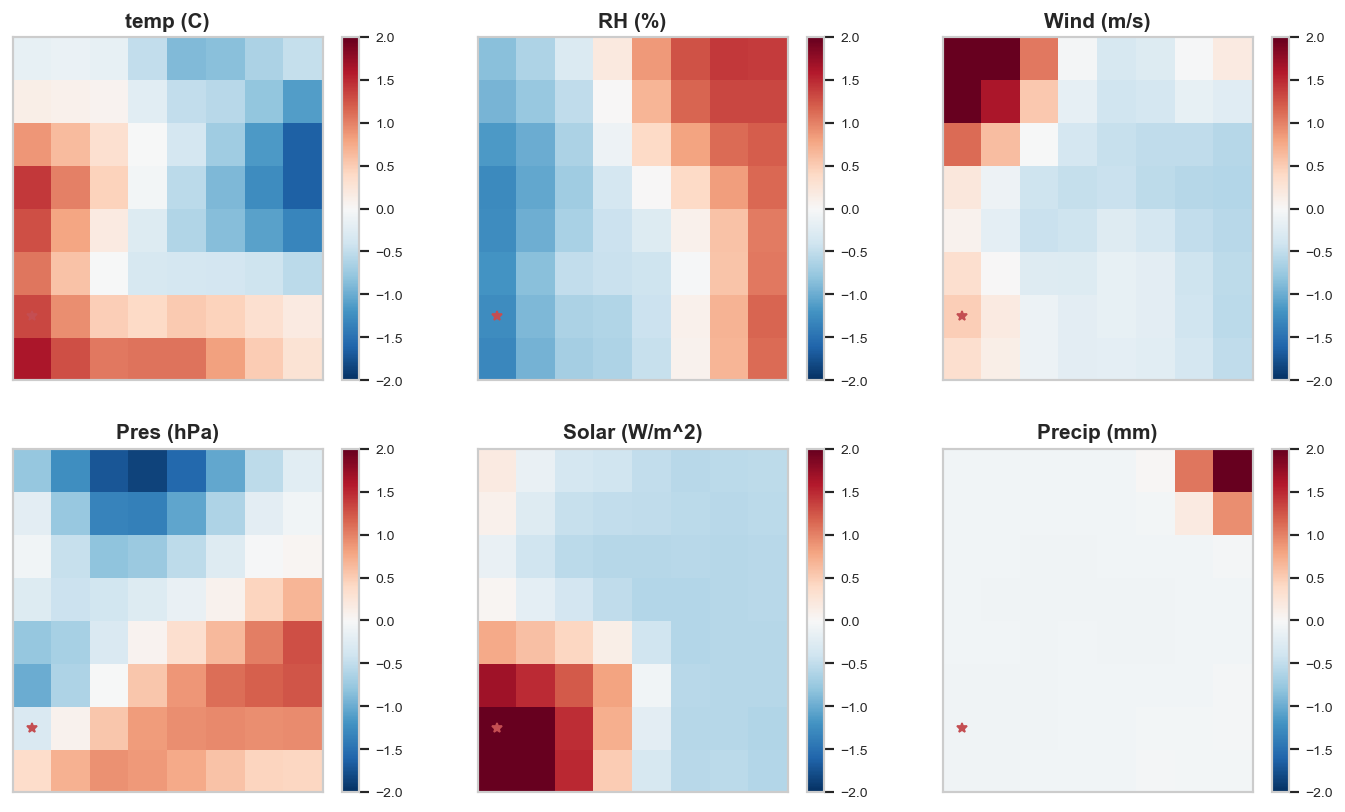

In [36]:
my_cmap = plt.cm.get_cmap('RdBu_r')

# make the plot
plt.figure(figsize=(17*.8,10*.8))
for ind in range(0,np.size(codebook,axis=2)):
    weights = codebook[:,:,ind]
#     weights = np.abs(weights)
#     weights[np.isnan(weights)==True] = 0.
#     weights[weights<=0.] = 1.e-10
    ax = plt.subplot(2, 3, ind+1)
    
    if(np.min(weights.shape[1]==1)):
        weights = np.append(weights,weights,axis=1)
    elif(np.min(weights.shape[0]==1)):    
        weights = np.append(weights,weights,axis=0)

    plt.axis([0, weights.shape[1], 0, weights.shape[0]])
#     if(names[ind] in 'Precip (mm)'):
#         pl = plt.pcolormesh(weights, cmap = my_cmap, norm=colors.LogNorm(vmin=weights.min(), vmax=weights.max()))
#         #pl = plt.pcolor(weights, cmap = my_cmap)
#     else:
    pl = plt.pcolormesh(weights, cmap = my_cmap)

    plt.plot(neuron_sample[1]+.5,neuron_sample[0]+.5,'*r')    
    plt.yticks([])
    plt.xticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8) 
    plt.title(names[ind])
    plt.clim(-2,2)
plt.show()

### Plot the "hits" map
The "Hits Map" is a map of how many times a particular sample falls into a particular SOM. In our example here, what is the number of samples that look like each SOM? We see from the hits map below where the most frequent SOMs/states of the atmosphere lie. So, we can go and look at the figure above and see what values the different variables take-on during this time. Looks like "cold/moist/low wind/mix of pressures/cloudy/precipitating a little" (at least that is what it looked like when I ran this!).

Text(0.5, 1, 'Frequencies')

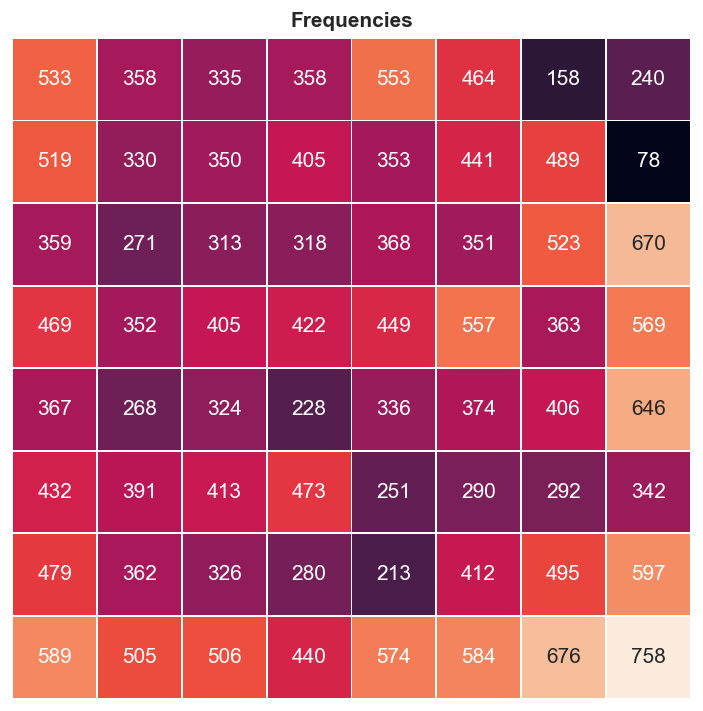

In [37]:
frequencies = np.zeros((dim[0],dim[1]))
x = np.zeros((dim[0],dim[1]))
y = np.zeros((dim[0],dim[1]))
for position, values in som.win_map(data).items():
    frequencies[position[0], position[1]] = len(values)
    x[position[0], position[1]] = position[0]
    y[position[0], position[1]] = position[1]
    
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(np.flipud(frequencies), annot=True, fmt='g', linewidths=.5, ax=ax, cbar=False)
ax.axis('off')
plt.title('Frequencies')    

## EOF Analysis

In [38]:
Y = np.copy(data)
Ymean = np.nanmean(Y,axis = 0)
X = Y - Ymean

# standardize the data - call it "Xw"
Xstd = np.nanstd(X,axis = 0)
Xw = X/Xstd

C = 1./np.size(Xw,axis = 0)*np.dot(np.transpose(Xw),Xw) 
print('shape of Cov Matrix = ' + str(np.shape(C)))
print(C)

# calculate eigenvalues and eigenvectors of C; lam should be 7x1, E should be 7x7
lam, E = LA.eig(C) 

# sort eigenvalues and vector by the largest to smallest eigenvalues
i = np.flipud(np.argsort(lam))
lam = lam[i]
E = E[:,i]

pve = 100.*lam/np.sum(lam)

shape of Cov Matrix = (6, 6)
[[ 1.         -0.58433937  0.1484486   0.02699085  0.45989546 -0.00721238]
 [-0.58433937  1.         -0.36147733  0.12727862 -0.51510527  0.10310595]
 [ 0.1484486  -0.36147733  1.         -0.2288541   0.17548417  0.04318623]
 [ 0.02699085  0.12727862 -0.2288541   1.          0.02220117 -0.00679556]
 [ 0.45989546 -0.51510527  0.17548417  0.02220117  1.         -0.03828645]
 [-0.00721238  0.10310595  0.04318623 -0.00679556 -0.03828645  1.        ]]


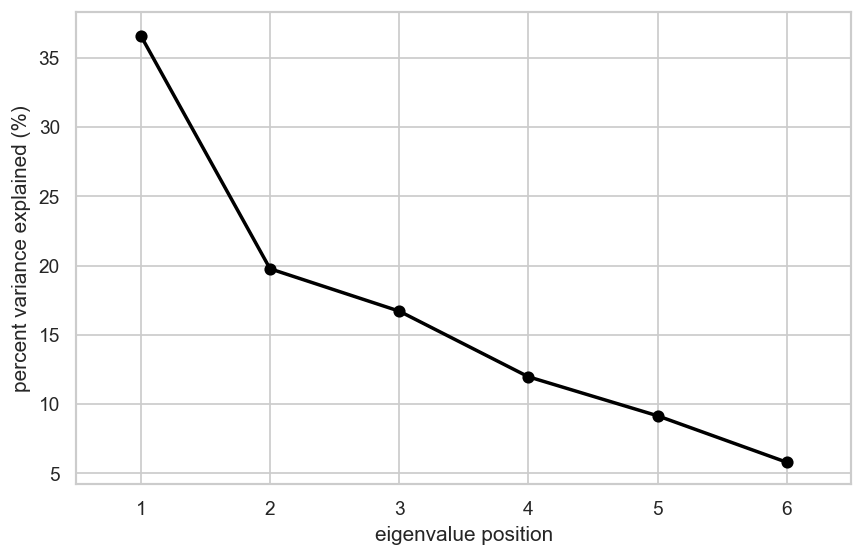

In [39]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,np.size(pve)+1.),pve,'o-',linewidth = 2, color = 'black')

plt.xlim(0.5, 6.5)
plt.xlabel('eigenvalue position')
plt.ylabel('percent variance explained (%)')

# plot error bars according to North et al.abs
# here we will assume that all of the data is independent (is that a good assumption?)
# such that Nstar = N
Nstar = np.size(X,axis = 0)
eb = pve*np.sqrt(2./Nstar)
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black')

plt.show()

In [40]:
#-----------MODIFY--------------------------
# which EOF do you want to plot?
eof_num = 1
#-------------------------------------------
# take only one eigenvector, user specified by "eof_num" above
e1 = E[:,eof_num-1] #e1 should be 7x1 or 1x7 depending on your software
# calculate the the PC associated with the EOF of interest
z1 = np.dot(Xw,e1) #z1 should be 50x1 or 1x50 depending on your software
# standardize z1
z1 = (z1-np.nanmean(z1))/np.nanstd(z1)

# calculate d1 for plotting in physical units, not standardized/weighted units,
# thus it uses the original "X" anomaly data
d1 = (1./np.size(X,axis=0))*np.dot(np.transpose(z1),X)

# calculate d1 for plotting in standardized/weighted units,
# thus it uses the "Xw" anomaly data
d1s = (1./np.size(Xw, axis = 0))*np.dot(np.transpose(z1),Xw)

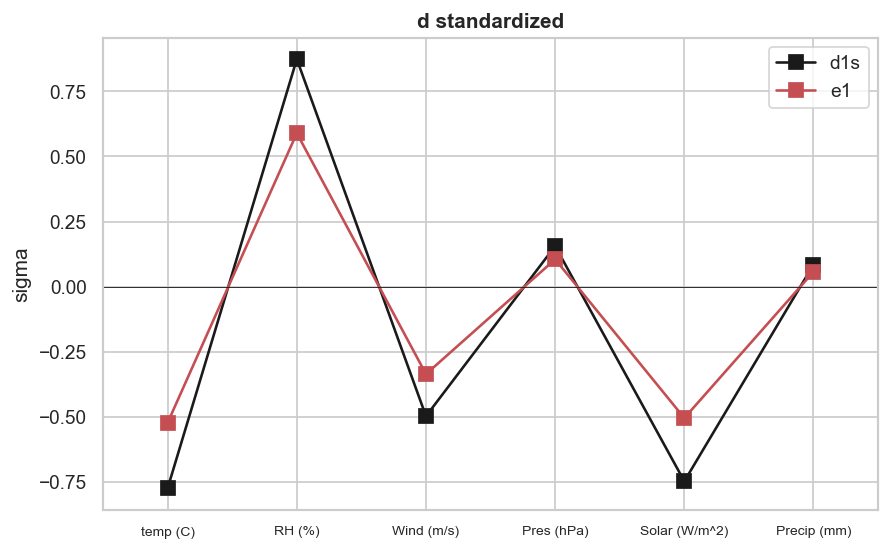

In [41]:
plt.figure(figsize=(8,5))

plt.plot(d1s,'s-k', label = 'd1s', markersize=8)
plt.plot(e1,'s-r', label = 'e1', markersize=8)

plt.xticks(np.arange(len(names)),names, fontsize = 8)
plt.xlim(-0.5, 5.5)

plt.legend()
plt.axhline(color='k',linewidth=.5)
plt.ylabel('sigma')
plt.title('d standardized')

plt.show()

In [42]:
print('PC '+ str(eof_num) + ' value for sample #' + str(sample) + ' = ' + str(np.around(z1[sample],3)))

PC 1 value for sample #710 = -2.195
